In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import readdy

In [2]:
system = readdy.ReactionDiffusionSystem(
        box_size=(10, 10, 10), periodic_boundary_conditions=[False, False, False], unit_system=None)
system.add_species("A", 1.0)
system.potentials.add_box(
    particle_type="A", force_constant=50., origin=[-4, -4, -4], extent=[8, 8, 8]
)

In [3]:
simulation = system.simulation(kernel="SingleCPU")

simulation.output_file = "out_msd.h5"
simulation.observe.particle_positions(stride=1)
init_pos = np.zeros((400, 3))
simulation.add_particles("A", init_pos)

In [4]:
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.run(n_steps=5000, timestep=1e-3, show_system=False)

Box(children=(Text(value=''), IntProgress(value=0)))

In [5]:
traj = readdy.Trajectory(simulation.output_file)
times, positions = traj.read_observable_particle_positions()
times = np.array(times) * 1e-3

In [6]:
# convert to pure numpy array to make use of fancy operations
T = len(positions)
N = len(positions[0])
pos = np.zeros(shape=(T, N, 3))
for t in range(T):
    for n in range(N):
        pos[t, n, 0] = positions[t][n][0]
        pos[t, n, 1] = positions[t][n][1]
        pos[t, n, 2] = positions[t][n][2]

difference = pos - init_pos
squared_displacements = np.sum(difference * difference, axis=2)  # sum over coordinates, per particle per timestep
squared_displacements = squared_displacements.transpose()  # T x N -> N x T

In [7]:
def average_across_first_axis(values):
    n_values = len(values)
    mean = np.sum(values, axis=0) / n_values
    difference = values - mean  # broadcasting starts with last axis
    std_dev = np.sqrt(np.sum(difference * difference, axis=0) / n_values)
    std_err = np.sqrt(np.sum(difference * difference, axis=0) / n_values ** 2)
    return mean, std_dev, std_err

mean, std_dev, std_err = average_across_first_axis(squared_displacements)

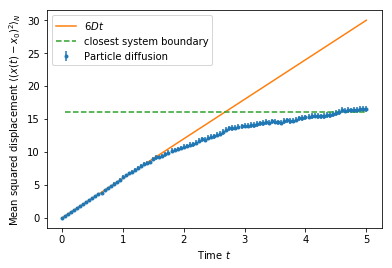

In [8]:
stride = 50
plt.errorbar(times[::stride], mean[::stride], yerr=std_err[::stride], fmt=".", label="Particle diffusion")
plt.plot(times[::stride], 6. * times[::stride], label=r"$6 D t$")
plt.plot([stride * 1e-3, times[-1]], [16., 16.], "--", label="closest system boundary")
plt.legend(loc="best")
plt.xlabel(r"Time $t$")
plt.ylabel(r"Mean squared displacement $\langle (x(t) - x_0)^2 \rangle_N$")
plt.show()